=== 年金制度シミュレーション ===
パラメータ: γ=2.0, β=0.7391, r=0.6386
生産性タイプ: [0.8027 1.     1.2457]
年金税率: 30.0%

問1: 年金制度なしの場合
年金なしの場合の政策関数を計算完了


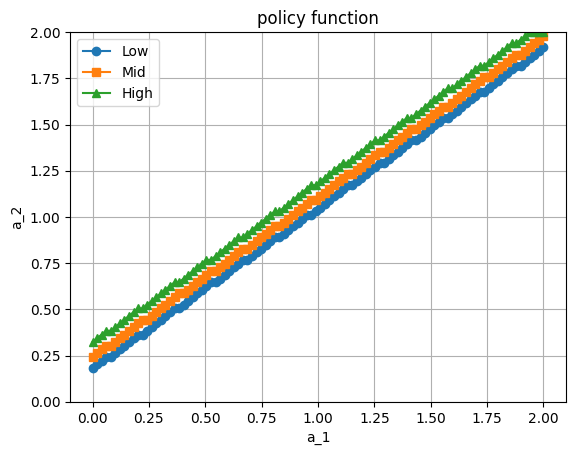


問2: 年金財政の計算
中年期の総税収: 0.3043
一人当たりの年金額: 0.4986

問3: 年金制度ありの場合
年金ありの場合の政策関数を計算完了


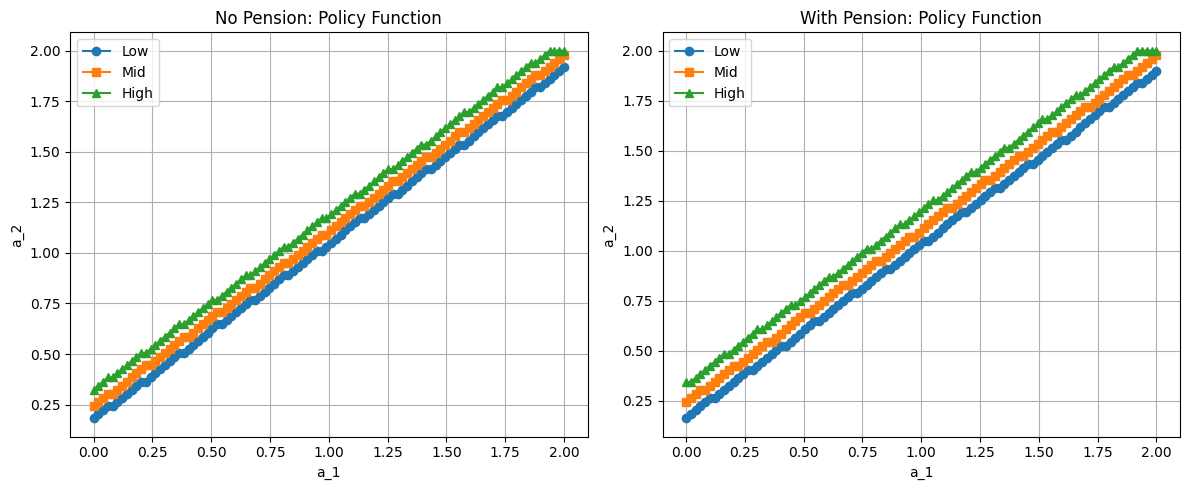


問3: 貯蓄行動の変化の比較表
生産性タイプ          年金なし            年金あり            変化（絶対）          変化（%）       
--------------------------------------------------------------------------------
低生産性            1.0473          1.0327          -0.0145         -1.39       
中生産性            1.1087          1.1071          -0.0016         -0.15       
高生産性            1.1867          1.1994          0.0127          1.07        
--------------------------------------------------------------------------------
全体平均            1.1142          1.1131          -0.0011         -0.10       

問4: 期待生涯効用の比較表
生産性タイプ          年金なし            年金あり            変化（絶対）          変化（%）       
--------------------------------------------------------------------------------
低生産性            -3.413949       -3.335297       0.078652        2.30        
中生産性            -2.801381       -2.793856       0.007525        0.27        
高生産性            -2.295552       -2.329590       -0.034038       -1.48       
-------------------------------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 日本語フォントの設定
rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def util(c, gamma):
    """効用関数（ゼロ除算防止つき）"""
    epsilon = 1e-8  # ゼロを避けるための微小値
    c = np.maximum(c, epsilon)  # c が 0 以下のとき epsilon に置換
    if gamma == 1.0:
        return np.log(c)
    else:
        return (c**(1 - gamma)) / (1 - gamma)


# パラメータ設定
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
tau = 0.30  # 年金税率

# 若年期の生産性タイプ
l = np.array([0.8027, 1.0, 1.2457])
NL = 3

# 生産性遷移行列
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])

# 人口比率
mu_1 = np.array([1.0/NL, 1.0/NL, 1.0/NL])
mu_2 = np.zeros(NL)

for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il, ilp]*mu_1[il]

# 資産グリッド
a_l = 0.0
a_u = 2.0
NA = 100
a = np.linspace(a_l, a_u, NA)

print("=== 年金制度シミュレーション ===")
print(f"パラメータ: γ={gamma}, β={beta:.4f}, r={r:.4f}")
print(f"生産性タイプ: {l}")
print(f"年金税率: {tau*100}%")
print()

# 問1: 年金なしの場合の解
print("問1: 年金制度なしの場合")

# 初期化
v_no_pension = np.zeros((3, NA, NL))
iaplus_no_pension = np.zeros((3, NA, NL), dtype=int)
aplus_no_pension = np.zeros((3, NA, NL))

# 後退誘導法

# 第3期 (老年期)
for ia in range(NA):
    v_no_pension[2, ia, :] = util((1.0+r)*a[ia], gamma)

# 第2期 (中年期)
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            consumption = l[il] + (1.0+r)*a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta*v_no_pension[2, iap, 0]
            else:
                reward[iap] = -np.inf
        iaplus_no_pension[1, ia, il] = np.argmax(reward)
        aplus_no_pension[1, ia, il] = a[iaplus_no_pension[1, ia, il]]
        v_no_pension[1, ia, il] = reward[iaplus_no_pension[1, ia, il]]

# 第1期 (若年期)
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            consumption = l[il] + (1.0+r)*a[ia] - a[iap]
            if consumption > 0:
                EV = 0.0
                for ilp in range(NL):
                    EV += prob[il, ilp]*v_no_pension[1, iap, ilp]
                reward[iap] = util(consumption, gamma) + beta*EV
            else:
                reward[iap] = -np.inf
        iaplus_no_pension[0, ia, il] = np.argmax(reward)
        aplus_no_pension[0, ia, il] = a[iaplus_no_pension[0, ia, il]]
        v_no_pension[0, ia, il] = reward[iaplus_no_pension[0, ia, il]]

print("年金なしの場合の政策関数を計算完了")
plt.figure()
plt.plot(a, aplus_no_pension[0, :, 0], marker='o', label='Low')
plt.plot(a, aplus_no_pension[0, :, 1], marker='s', label='Mid')
plt.plot(a, aplus_no_pension[0, :, 2], marker='^', label='High')
plt.title("policy function")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()
# 問2: 年金財政の計算
print("\n問2: 年金財政の計算")

# 中年期の総税収を計算
total_tax_revenue = 0.0
for il in range(NL):
    total_tax_revenue += mu_2[il] * tau * l[il]

print(f"中年期の総税収: {total_tax_revenue:.4f}")

# 老年期の年金額 (利子を含む)
pension_per_person = total_tax_revenue * (1.0 + r)
print(f"一人当たりの年金額: {pension_per_person:.4f}")

# 問3: 年金ありの場合の解
print("\n問3: 年金制度ありの場合")

# 初期化
v_with_pension = np.zeros((3, NA, NL))
iaplus_with_pension = np.zeros((3, NA, NL), dtype=int)
aplus_with_pension = np.zeros((3, NA, NL))

# 後退誘導法

# 第3期 (老年期) - 年金あり
for ia in range(NA):
    v_with_pension[2, ia, :] = util(pension_per_person + (1.0+r)*a[ia], gamma)

# 第2期 (中年期) - 年金税あり
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        after_tax_income = (1.0 - tau) * l[il]
        for iap in range(NA):
            consumption = after_tax_income + (1.0+r)*a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta*v_with_pension[2, iap, 0]
            else:
                reward[iap] = -np.inf
        iaplus_with_pension[1, ia, il] = np.argmax(reward)
        aplus_with_pension[1, ia, il] = a[iaplus_with_pension[1, ia, il]]
        v_with_pension[1, ia, il] = reward[iaplus_with_pension[1, ia, il]]

# 第1期 (若年期) - 年金税なし
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            consumption = l[il] + (1.0+r)*a[ia] - a[iap]
            if consumption > 0:
                EV = 0.0
                for ilp in range(NL):
                    EV += prob[il, ilp]*v_with_pension[1, iap, ilp]
                reward[iap] = util(consumption, gamma) + beta*EV
            else:
                reward[iap] = -np.inf
        iaplus_with_pension[0, ia, il] = np.argmax(reward)
        aplus_with_pension[0, ia, il] = a[iaplus_with_pension[0, ia, il]]
        v_with_pension[0, ia, il] = reward[iaplus_with_pension[0, ia, il]]

print("年金ありの場合の政策関数を計算完了")

# グラフ作成
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 年金なしの場合の若年期政策関数
axes[0].plot(a, aplus_no_pension[0, :, 0], marker='o', label='Low')
axes[0].plot(a, aplus_no_pension[0, :, 1], marker='s', label='Mid')
axes[0].plot(a, aplus_no_pension[0, :, 2], marker='^', label='High')
axes[0].set_title("No Pension: Policy Function")
axes[0].set_xlabel("a_1")
axes[0].set_ylabel("a_2")
axes[0].grid(True)
axes[0].legend()

# 年金ありの場合の若年期政策関数
axes[1].plot(a, aplus_with_pension[0, :, 0], marker='o', label='Low')
axes[1].plot(a, aplus_with_pension[0, :, 1], marker='s', label='Mid')
axes[1].plot(a, aplus_with_pension[0, :, 2], marker='^', label='High')
axes[1].set_title("With Pension: Policy Function")
axes[1].set_xlabel("a_1")
axes[1].set_ylabel("a_2")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# 問3: 貯蓄行動の変化の比較表（修正版）
print("\n問3: 貯蓄行動の変化の比較表")
print("=" * 80)

type_names = ['低生産性', '中生産性', '高生産性']

print(f"{'生産性タイプ':<15} {'年金なし':<15} {'年金あり':<15} {'変化（絶対）':<15} {'変化（%）':<12}")
print("-" * 80)

# 平均貯蓄の計算と比較
for il in range(NL):
    avg_savings_no_pension = np.mean(aplus_no_pension[0, :, il])
    avg_savings_with_pension = np.mean(aplus_with_pension[0, :, il])
    absolute_change = avg_savings_with_pension - avg_savings_no_pension
    percentage_change = (absolute_change / avg_savings_no_pension * 100) if avg_savings_no_pension > 0 else 0

    print(f"{type_names[il]:<15} {avg_savings_no_pension:<15.4f} {avg_savings_with_pension:<15.4f} {absolute_change:<15.4f} {percentage_change:<12.2f}")

# 全体の平均
overall_avg_no_pension = np.mean([np.mean(aplus_no_pension[0, :, il]) for il in range(NL)])
overall_avg_with_pension = np.mean([np.mean(aplus_with_pension[0, :, il]) for il in range(NL)])
overall_absolute_change = overall_avg_with_pension - overall_avg_no_pension
overall_percentage_change = (overall_absolute_change / overall_avg_no_pension * 100) if overall_avg_no_pension > 0 else 0

print("-" * 80)
print(f"{'全体平均':<15} {overall_avg_no_pension:<15.4f} {overall_avg_with_pension:<15.4f} {overall_absolute_change:<15.4f} {overall_percentage_change:<12.2f}")

# 問4: 期待生涯効用の比較 (初期資産=0)
print("\n問4: 期待生涯効用の比較表")
print("=" * 80)

# 初期資産0での期待生涯効用
ia_zero = 0  # a=0のインデックス

welfare_no_pension = 0.0
welfare_with_pension = 0.0

print(f"{'生産性タイプ':<15} {'年金なし':<15} {'年金あり':<15} {'変化（絶対）':<15} {'変化（%）':<12}")
print("-" * 80)

utility_changes = []
for il in range(NL):
    utility_no_pension = v_no_pension[0, ia_zero, il]
    utility_with_pension = v_with_pension[0, ia_zero, il]
    utility_change = utility_with_pension - utility_no_pension
    change_rate = (utility_change / abs(utility_no_pension) * 100) if utility_no_pension != 0 else 0

    utility_changes.append(utility_change)
    welfare_no_pension += mu_1[il] * utility_no_pension
    welfare_with_pension += mu_1[il] * utility_with_pension

    print(f"{type_names[il]:<15} {utility_no_pension:<15.6f} {utility_with_pension:<15.6f} {utility_change:<15.6f} {change_rate:<12.2f}")

print("-" * 80)
overall_welfare_change = welfare_with_pension - welfare_no_pension
overall_change_rate = (overall_welfare_change / abs(welfare_no_pension) * 100) if welfare_no_pension != 0 else 0

print(f"{'人口加重平均':<15} {welfare_no_pension:<15.6f} {welfare_with_pension:<15.6f} {overall_welfare_change:<15.6f} {overall_change_rate:<12.2f}")

# 効用変化の詳細分析
print(f"\n効用変化の詳細分析:")
print("-" * 40)
welfare_change = welfare_with_pension - welfare_no_pension
print(f"経済全体の平均期待生涯効用変化: {welfare_change:.6f}")
print(f"年金制度の導入により期待生涯効用は{'増加' if welfare_change > 0 else '減少'}しました")

# 各タイプの便益・負担の分析
print(f"\n各生産性タイプの便益・負担:")
print("-" * 40)
for il in range(NL):
    if utility_changes[il] > 0:
        print(f"{type_names[il]}: 便益 (+{utility_changes[il]:.6f})")
    else:
        print(f"{type_names[il]}: 負担 ({utility_changes[il]:.6f})")

# 所得再分配効果の分析
redistribution_effect = utility_changes[0] - utility_changes[2]  # 低生産性 - 高生産性
print(f"\n所得再分配効果 (低生産性 - 高生産性): {redistribution_effect:.6f}")
print(f"年金制度は{'所得再分配効果がある' if redistribution_effect > 0 else '逆進的な効果がある'}")